In [16]:
%matplotlib inline

import sys
import PIL.Image
import scipy.misc, scipy.io, scipy.optimize, scipy.special

from numpy import *
import pylab
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.mlab as mlaba

from util import Util
import timeit
import cProfile, pstats, io

EX_DIRECTORY_PATH = './data/'

def recodeLabel( y, k ):
    m = shape(y)[0]
    out = zeros( ( k, m ) )
    
    for i in range(0, m):
        out[y[i]-1, i] = 1

    return out

def mod( length, divisor ):
    dividend = array([x for x in range(1, length+1)])
    divisor  = array([divisor for x in range(1, length+1)])
    return mod( dividend, divisor ).reshape(1, length )

def sigmoid( z ):
    return scipy.special.expit(z)

def sigmoidGradient( z ):
    sig = sigmoid(z)
    return sig * (1 - sig)

def predict( X, theta1, theta2 ):
    a1 = r_[ones((1, 1)), X.reshape( shape(X)[0], 1 )]
    z2 = sigmoid( theta1.dot( a1 ))
    z2 = r_[ones((1, 1)), z2]
    z3 = sigmoid(theta2.dot( z2 ))
    return argmax(z3) + 1

def paramUnroll( nn_params, input_layer_size, hidden_layer_size, num_labels ):
    theta1_elems = ( input_layer_size + 1 ) * hidden_layer_size
    theta1_size  = ( input_layer_size + 1, hidden_layer_size  )
    theta2_size  = ( hidden_layer_size + 1, num_labels )

    theta1 = nn_params[:theta1_elems].T.reshape( theta1_size ).T    
    theta2 = nn_params[theta1_elems:].T.reshape( theta2_size ).T

    return (theta1, theta2)

def feedForward( theta1, theta2, X, X_bias = None ):
    one_rows = ones((1, shape(X)[0] ))
    
    a1 = r_[one_rows, X.T]  if X_bias is None else X_bias
    z2 = theta1.dot( a1 )
    a2 = sigmoid(z2)
    a2 = r_[one_rows, a2] 
    z3 = theta2.dot( a2 )
    a3 = sigmoid( z3 )

    return (a1, a2, a3, z2, z3)

def computeCost( nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lamda, yk = None, X_bias = None ):
    m, n                 = shape( X )
    theta1, theta2         = paramUnroll( nn_params, input_layer_size, hidden_layer_size, num_labels )
    a1, a2, a3, z2, z3     = feedForward( theta1, theta2, X, X_bias )

    # calculating cost
    if yk is None:
        yk = recodeLabel( y, num_labels )
        assert shape(yk) == shape(a3), "Error, shape of recoded y is different from a3"

    term1         = -yk * log( a3 )
    term2         = (1 - yk) * log( 1 - a3 )
    left_term     = sum(term1 - term2) / m
    right_term     = sum(theta1[:,1:] ** 2) + sum(theta2[:,1:] ** 2)

    return left_term + right_term * lamda / (2 * m)

def computeGradient( nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lamda, yk = None, X_bias = None ):
    m, n                 = shape( X )
    theta1, theta2         = paramUnroll( nn_params, input_layer_size, hidden_layer_size, num_labels )
    a1, a2, a3, z2, z3     = feedForward( theta1, theta2, X, X_bias )

    # back propagate
    if yk is None:
        yk = recodeLabel( y, num_labels )
        assert shape(yk) == shape(a3), "Error, shape of recoded y is different from a3"

    sigma3 = a3 - yk
    sigma2 = theta2.T.dot( sigma3 ) * sigmoidGradient( r_[ones((1, m)), z2 ] )
    sigma2 = sigma2[1:,:]
    accum1 = sigma2.dot( a1.T ) / m
    accum2 = sigma3.dot( a2.T ) / m

    accum1[:,1:] = accum1[:,1:] + (theta1[:,1:] * lamda / m)
    accum2[:,1:] = accum2[:,1:] + (theta2[:,1:] * lamda / m)
    accum = array([accum1.T.reshape(-1).tolist() + accum2.T.reshape(-1).tolist()]).T
    return ndarray.flatten(accum)

def nnCostFunction( nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lamda ):
    m, n                 = shape( X )
    theta1, theta2         = paramUnroll( nn_params, input_layer_size, hidden_layer_size, num_labels )
    a1, a2, a3, z2, z3     = feedForward( theta1, theta2, X )

    # calculating cost
    yk             = recodeLabel( y.T, num_labels )
    assert shape(yk) == shape(a3), "Error, shape of recoded y is different from a3"

    term1         = -yk * log( a3 )
    term2         = (1-yk) * log( 1 - a3 )
    left_term     = sum(term1 - term2) / m
    right_term     = sum(theta1[:,1:] ** 2) + sum(theta2[:,1:] ** 2)
    right_term     = right_term * lamda / (2 * m)
    cost         = left_term + right_term

    # back propagate
    sigma3 = a3 - yk
    sigma2 = theta2.T.dot( sigma3 ) * sigmoidGradient( r_[ ones((1, m)), z2 ] )
    sigma2 = sigma2[1:,:]

    accum1 = sigma2.dot( a1.T ) / m
    accum2 = sigma3.dot( a2.T ) / m

    accum1[:,1:] = accum1[:,1:] + (theta1[:,1:] * lamda / m)
    accum2[:,1:] = accum2[:,1:] + (theta2[:,1:] * lamda / m)

    gradient      = array([accum1.T.reshape(-1).tolist() + accum2.T.reshape(-1).tolist()]).T

    return (cost, gradient)

def randInitializeWeights(L_in, L_out):
    e = 0.12
    w = random.random((L_out, L_in + 1)) * 2 * e - e
    return w

def debugInitializeWeights(fan_out, fan_in):
    num_elements = fan_out * (1+fan_in)
    w = array([sin(x) / 10 for x in range(1, num_elements+1)])
    w = w.reshape( 1+fan_in, fan_out ).T
    return w

def computeNumericalGradient( theta, input_layer_size, hidden_layer_size, num_labels, X, y, lamda ):
    numgrad     = zeros( shape(theta) )
    perturb     = zeros( shape(theta) ) #38 x 1
    e = 1e-4

    num_elements = shape(theta)[0]
    yk = recodeLabel( y, num_labels )

    for p in range(0, num_elements) :
        perturb[p] = e
        loss1 = computeCost( theta - perturb, input_layer_size, hidden_layer_size, num_labels, X, y, lamda, yk )
        loss2 = computeCost( theta + perturb, input_layer_size, hidden_layer_size, num_labels, X, y, lamda, yk )
        numgrad[p] = (loss2 - loss1) / (2 * e)
        perturb[p] = 0

    return numgrad

def checkNNGradients( lamda = 0.0 ):
    input_layer_size     = 3
    hidden_layer_size     = 5
    num_labels             = 3
    m                     = 5

    theta1 = debugInitializeWeights( hidden_layer_size, input_layer_size )
    theta2 = debugInitializeWeights( num_labels, hidden_layer_size )

    X = debugInitializeWeights( m, input_layer_size - 1 )
    y = 1 + mod( m, num_labels )

    nn_params     = array([theta1.T.reshape(-1).tolist() + theta2.T.reshape(-1).tolist()]).T
    gradient     = nnCostFunction( nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lamda )[1]
    numgrad     = computeNumericalGradient( nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lamda )
    diff = linalg.norm( numgrad - gradient ) / (linalg.norm( numgrad + gradient ))
    print (diff)

def displayData( X, theta1 = None, theta2 = None ):
    m, n = shape( X )
    width = int(sqrt( n ))
    rows, cols = 5, 5
    print("width:",width,"row:",rows,"cols:",cols);
    out = zeros((width * rows, width * cols))

    rand_indices = random.permutation( m )[0:rows * cols]

    counter = 0
    for y in range(0, rows):
        for x in range(0, cols):
            start_x = x * width
            start_y = y * width
            out[start_x:start_x+width, start_y:start_y+width] = X[rand_indices[counter]].reshape(width, width).T
            counter += 1

    img     = Util.toimage( out )
    figure  = pyplot.figure()
    axes    = figure.add_subplot(111)
    axes.imshow( img )


    if theta1 is not None and theta2 is not None:
        result_matrix     = []
        
        for idx in rand_indices:
            result = predict( X[idx], theta1, theta2 )
            result_matrix.append( result )

        result_matrix = array( result_matrix ).reshape( rows, cols ).transpose()
        print(result_matrix)

    pyplot.show( )

def part1_1():
    mat = scipy.io.loadmat( EX_DIRECTORY_PATH + "ex4data1.mat" )
    X, y = mat['X'], mat['y']
    displayData( X )

def part1_2():
    mat = scipy.io.loadmat( EX_DIRECTORY_PATH + "ex4data1.mat" )
    X, y = mat['X'], mat['y']
    m, n = shape(X)

    # Load the weights
    mat = scipy.io.loadmat( EX_DIRECTORY_PATH + "ex4weights.mat" )
    theta1, theta2 = mat['Theta1'], mat['Theta2']

    nn_params = [theta1.T.flatten(), theta2.T.flatten()]

def part1_3():
    mat = scipy.io.loadmat( EX_DIRECTORY_PATH + "ex4data1.mat" )
    X, y = mat['X'], mat['y']

    # Load the weights
    mat = scipy.io.loadmat( EX_DIRECTORY_PATH + "ex4weights.mat" )
    theta1, theta2 = mat['Theta1'], mat['Theta2']

    input_layer_size      = 400
    hidden_layer_size     = 25
    num_labels             = 10
    lamda                 = 0

    params = r_[theta1.T.flatten(), theta2.T.flatten()]

    print(computeGradient( params, input_layer_size, hidden_layer_size, num_labels, X, y, lamda ))
    print(computeCost( params, input_layer_size, hidden_layer_size, num_labels, X, y, lamda ))

def part1_4():
    mat = scipy.io.loadmat( EX_DIRECTORY_PATH +  "ex4data1.mat" )
    X, y = mat['X'], mat['y']

    # Load the weights
    mat = scipy.io.loadmat( EX_DIRECTORY_PATH +  "ex4weights.mat" )
    theta1, theta2 = mat['Theta1'], mat['Theta2']

    input_layer_size      = 400
    hidden_layer_size     = 25
    num_labels             = 10
    lamda                 = 1

    params = r_[theta1.T.flatten(), theta2.T.flatten()]
    print (computeCost( params, input_layer_size, hidden_layer_size, num_labels, X, y, lamda ))

def part2_1():
    print(sigmoidGradient( 0 ))
    print(sigmoidGradient( array([1, -0.5, 0, 0.5, 1]) ))

def part2_2():
    theta1 = randInitializeWeights( 400, 25 )
    theta2 = randInitializeWeights( 25, 10 )
    unraveled = r_[theta1.T.flatten(), theta2.T.flatten()]
    
def part2_3():
    mat = scipy.io.loadmat( EX_DIRECTORY_PATH +  "ex4data1.mat" )
    X, y = mat['X'], mat['y']
    m, n = shape(X)

    mat = scipy.io.loadmat( EX_DIRECTORY_PATH +  "ex4weights.mat" )
    theta1, theta2 = mat['Theta1'], mat['Theta2']

    
    input_layer_size      = 400
    hidden_layer_size     = 25
    num_labels             = 10
    lamda                 = 1

    unraveled = r_[theta1.T.flatten(), theta2.T.flatten()]

    J, theta = nnCostFunction( unraveled, input_layer_size, hidden_layer_size, num_labels, X, y.T, lamda )
    print(J)
    print(theta)


def part2_4():
    mat = scipy.io.loadmat( EX_DIRECTORY_PATH +  "ex4data1.mat" )
    X, y = mat['X'], mat['y']
    m, n = shape(X)

    mat = scipy.io.loadmat( EX_DIRECTORY_PATH +  "ex4weights.mat" )
    theta1, theta2 = mat['Theta1'], mat['Theta2']
    
    input_layer_size      = 400
    hidden_layer_size     = 25
    num_labels             = 10
    lamda                 = 1

    unraveled = r_[theta1.T.flatten(), theta2.T.flatten()]

    print(computeNumericalGradient( unraveled, input_layer_size, hidden_layer_size, num_labels, X, y, lamda ))


def part2_5():
    mat = scipy.io.loadmat( EX_DIRECTORY_PATH +  "ex4data1.mat" )
    X, y = mat['X'], mat['y']
    m, n = shape(X)

    mat = scipy.io.loadmat( EX_DIRECTORY_PATH +  "ex4weights.mat" )
    theta1, theta2 = mat['Theta1'], mat['Theta2']

    input_layer_size      = 400
    hidden_layer_size     = 25
    num_labels             = 10
    lamda                 = 3

    unraveled = r_[theta1.T.flatten(), theta2.T.flatten()]
    J, theta = nnCostFunction( unraveled, input_layer_size, hidden_layer_size, num_labels, X, y.T, lamda )
    print(J)

def part2_6():
    mat = scipy.io.loadmat( EX_DIRECTORY_PATH +  "ex4data1.mat" )
    X, y = mat['X'], mat['y']
    m, n = shape(X)

    input_layer_size      = 400
    hidden_layer_size     = 25
    num_labels             = 10
    lamda                 = 1.0

    theta1 = randInitializeWeights( 400, 25 )
    theta2 = randInitializeWeights( 25, 10 )

    yk             = recodeLabel( y, num_labels )
    unraveled     = r_[theta1.T.flatten(), theta2.T.flatten()]

    X_bias = r_[ ones((1, shape(X)[0] )), X.T] 

    result = scipy.optimize.fmin_cg( computeCost, fprime=computeGradient, x0=unraveled, \
                                    args=(input_layer_size, hidden_layer_size, num_labels, X, y, lamda, yk, X_bias), \
                                    maxiter=500, disp=True, full_output=True )
    print(result[1])
    theta1, theta2         = paramUnroll( result[0], input_layer_size, hidden_layer_size, num_labels )

    displayData( X, theta1, theta2 )

    counter = 0
    for i in range(0, m):
        prediction = predict( X[i], theta1, theta2 )
        actual = y[i]
        if( prediction == actual ):
            counter+=1
    print(counter * 100 / m)

In [5]:
def main():
    set_printoptions(precision=6, linewidth=200)

width: 20 row: 5 cols: 5


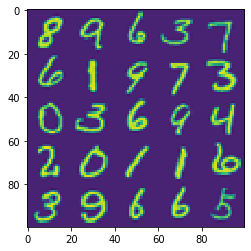

In [6]:
    part1_1()

In [7]:
    part1_2()

In [8]:
    part1_3()

[ 6.18712766e-05  9.38798109e-05 -1.92593606e-04 ...  1.27957448e-03
  1.35707295e-03  7.73329872e-04]
0.28762916516131887


In [9]:
    part1_4()

0.3837698590909236


In [10]:
    part2_1()

0.25
[0.19661193 0.23500371 0.25       0.23500371 0.19661193]


In [11]:
    part2_2()

In [12]:
    part2_3()

0.3837698590909236
[[ 6.18712766e-05]
 [ 9.38798109e-05]
 [-1.92593606e-04]
 ...
 [ 8.57546470e-04]
 [ 9.30689893e-04]
 [ 5.07825789e-04]]


In [13]:
    # part2_4() #real slow

In [14]:
    part2_5()

0.5760512469501331


         Current function value: 0.314954
         Iterations: 500
         Function evaluations: 1167
         Gradient evaluations: 1167
0.314954139729873
width: 20 row: 5 cols: 5
[[ 4  6 10  3  7]
 [10  7  8  6  4]
 [10  3  9 10  8]
 [ 9  5  8  1  8]
 [ 2 10  2  6  4]]


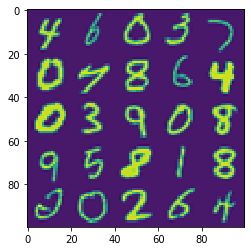

99.52


In [15]:
    part2_6()

In [ ]:
if __name__ == '__main__':
    main()